In [61]:
!pip install lightgbm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.3 MB/s  0:00:00


In [1]:
#!/usr/bin/env python3
import os
import glob
import joblib
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [2]:
def pick_best_model(group: pd.DataFrame) -> str:
    em_w = float(os.getenv("ROUTER_EM_WEIGHT", "0.25"))
    lat_w = float(os.getenv("ROUTER_LAT_WEIGHT", "0.0002"))

    inf_ms = group.get("inference_ms", pd.Series([0.0] * len(group))).fillna(
        group.get("client_elapsed_ms", pd.Series([0.0] * len(group))).fillna(0.0)
    )
    utility = (
        group.get("answer_cosine_sim", 0.0).fillna(0.0)
        + em_w * group.get("exact_match", 0.0).fillna(0.0)
        - lat_w * inf_ms
    )

    best_idx = utility.idxmax()
    return str(group.loc[best_idx, "model"])

In [23]:
results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
out_path = os.getenv("ROUTER_MODEL_PATH", "/data/router_model/router_model.joblib")

csvs = sorted(glob.glob(results_glob, recursive=True))
if not csvs:
    raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)
df.columns

Index(['collection', 'dataset', 'story_id', 'question_id', 'question',
       'true_answer', 'predicted_answer', 'model', 'confidence',
       'answer_cosine_sim', 'exact_match', 'type', 'level', 'retrieval_k',
       'router_retrieval_ms', 'inference_ms', 'end_to_end_ms',
       'client_elapsed_ms', 'local_retrieval_ms', 'retr_cache_hit',
       'question_hash', 'prompt_chars', 'context_chars'],
      dtype='object')

In [19]:
def main():
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    out_path = os.getenv("ROUTER_MODEL_PATH", "/data/router_model/router_model.joblib")

    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    # --- normalize columns / make dataset always present ---
    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("").astype(str).str.strip().str.lower()

    # fallback: dataset := collection if empty
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    # ensure feature columns exist
    for c in ["prompt_chars", "context_chars", "retrieval_k"]:
        if c not in df.columns:
            df[c] = 0

    # must have these to train
    required = ["question_id", "model", "answer_cosine_sim", "exact_match"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise SystemExit(f"Missing required columns in eval CSV(s): {missing}")

    # group key (prefer question_id)
    key = "question_id"

    # labels: best model per question
    y = df.groupby(key).apply(pick_best_model)

    # features: first row per question
    first = df.groupby(key).first().copy()
    X = first[["dataset", "prompt_chars", "context_chars", "retrieval_k"]].copy()

    # build model
    cat = ["dataset"]
    num = ["prompt_chars", "context_chars", "retrieval_k"]

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
            ("num", "passthrough", num),
        ]
    )

    clf = LogisticRegression(max_iter=10000)

    pipe = Pipeline(steps=[("pre", pre), ("clf", clf)])
    pipe.fit(X, y)

    # os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # joblib.dump({"model": pipe}, out_path)
    # print(f"Saved router model: {out_path}")


In [20]:
if __name__ == "__main__":
    main()

/tmp/ipykernel_2151320/1182117579.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y = df.groupby(key).apply(pick_best_model)


In [30]:
csvs = sorted(glob.glob(results_glob, recursive=True))
if not csvs:
    raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)
len(df)

600

In [44]:
df.columns

Index(['collection', 'dataset', 'story_id', 'question_id', 'question',
       'true_answer', 'predicted_answer', 'model', 'confidence',
       'answer_cosine_sim', 'exact_match', 'type', 'level', 'retrieval_k',
       'router_retrieval_ms', 'inference_ms', 'end_to_end_ms',
       'client_elapsed_ms', 'local_retrieval_ms', 'retr_cache_hit',
       'question_hash', 'prompt_chars', 'context_chars'],
      dtype='object')

In [32]:
print("rows:", len(df))
print("unique questions:", df["question_id"].nunique())
print("models per question (approx):", len(df) / df["question_id"].nunique())
print("unique models:", df["model"].nunique())


rows: 600
unique questions: 200
models per question (approx): 3.0
unique models: 3


In [58]:
question, dataset, model, confidence, answer_cosine_sim, exact_match, router_retrieval_ms, inference_ms, prompt_chars, context_chars

,collection,dataset,story_id,question_id,question,true_answer,predicted_answer,model,confidence,answer_cosine_sim,...,retrieval_k,router_retrieval_ms,inference_ms,end_to_end_ms,client_elapsed_ms,local_retrieval_ms,retr_cache_hit,question_hash,prompt_chars,context_chars
0,hotpotqa,hotpotqa,NaN,5a7a06935542990198eaf050,Which magazine was started first Arthur's Maga...,Arthur's Magazine,Arthur's Magazine,llama3,0.85,1.000000,...,6,0.005002,302.126472,302.142379,314.586639,136.697769,False,6e09757d748d,70,5236
1,hotpotqa,hotpotqa,NaN,5a7a06935542990198eaf050,Which magazine was started first Arthur's Maga...,Arthur's Magazine,Arthur's Magazine,qwen2_5,0.85,1.000000,...,6,0.005136,316.251901,316.266435,324.970722,136.697769,False,6e09757d748d,70,5236
2,hotpotqa,hotpotqa,NaN,5a7a06935542990198eaf050,Which magazine was started first Arthur's Maga...,Arthur's Magazine,Arthur's Magazine,mistral,0.85,1.000000,...,6,0.004517,270.321176,270.335732,279.697180,136.697769,False,6e09757d748d,70,5236
3,hotpotqa,hotpotqa,NaN,5a879ab05542996e4f30887e,The Oberoi family is part of a hotel company t...,Delhi,Delhi,llama3,0.85,1.000000,...,6,0.005190,310.539260,310.556257,321.772575,61.217308,False,a2d6cf3d26a3,81,5816
4,hotpotqa,hotpotqa,NaN,5a879ab05542996e4f30887e,The Oberoi family is part of a hotel company t...,Delhi,Delhi,qwen2_5,0.85,1.000000,...,6,0.005054,332.341728,332.357168,342.782974,61.217308,False,a2d6cf3d26a3,81,5816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,narrativeqa,narrativeqa,00950a3641e6a28b04a6fabf6334140e2deaa9fd,00950a3641e6a28b04a6fabf6334140e2deaa9fd::q98,What city has Olivia fled from?,Olivia has fled from Akif.Akif,unknown,qwen2_5,0.15,0.186501,...,6,0.005313,386.604054,386.617187,397.042990,480.764151,False,f244d0d26d70,31,8051
596,narrativeqa,narrativeqa,00950a3641e6a28b04a6fabf6334140e2deaa9fd,00950a3641e6a28b04a6fabf6334140e2deaa9fd::q98,What city has Olivia fled from?,Olivia has fled from Akif.Akif,Unknown (The context does not provide informat...,mistral,0.85,0.666956,...,6,0.006018,431.908602,431.921200,442.307711,480.764151,False,f244d0d26d70,31,8051
597,narrativeqa,narrativeqa,00950a3641e6a28b04a6fabf6334140e2deaa9fd,00950a3641e6a28b04a6fabf6334140e2deaa9fd::q99,Who is chasing and pursuing olivia?,Shah Amurath is chasing Olivia.Shah,unknown,llama3,0.15,0.203123,...,6,0.006203,368.137840,368.151485,379.623175,465.050220,False,5b2f39476ebd,35,8052
598,narrativeqa,narrativeqa,00950a3641e6a28b04a6fabf6334140e2deaa9fd,00950a3641e6a28b04a6fabf6334140e2deaa9fd::q99,Who is chasing and pursuing olivia?,Shah Amurath is chasing Olivia.Shah,unknown,qwen2_5,0.15,0.203123,...,6,0.005640,378.992995,379.005448,389.173746,465.050220,False,5b2f39476ebd,35,8052


In [70]:
import os, glob
import pandas as pd
import numpy as np

# -----------------------------
# 1) Data loading / cleaning
# -----------------------------
def load_and_normalize(results_glob: str) -> pd.DataFrame:
    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("").astype(str).str.strip().str.lower()
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    for c in ["type", "level"]:
        if c not in df.columns:
            df[c] = "unknown"
        df[c] = df[c].fillna("unknown").astype(str).str.strip().str.lower()

    # required metrics
    if "exact_match" not in df.columns:
        raise SystemExit("Missing required column: exact_match")
    df["exact_match"] = pd.to_numeric(df["exact_match"], errors="coerce").fillna(0).astype(float)

    if "answer_cosine_sim" in df.columns:
        df["answer_cosine_sim"] = pd.to_numeric(df["answer_cosine_sim"], errors="coerce").fillna(0).astype(float)

    if "model" not in df.columns:
        raise SystemExit("Missing required column: model")
    df["model"] = df["model"].astype(str).str.strip().str.lower()

    if "question_id" not in df.columns:
        raise SystemExit("Missing required column: question_id")

    return df


# -----------------------------
# 2) Best model per dataset
# -----------------------------
def dataset_leaderboard(df: pd.DataFrame):
    """
    Returns:
      winners_df: one row per dataset with best model
      leaderboard_df: all dataset x model rows with metrics
    """
    agg = {"exact_match": "mean"}
    if "answer_cosine_sim" in df.columns:
        agg["answer_cosine_sim"] = "mean"

    leaderboard = (
        df.groupby(["dataset", "model"], as_index=False)
          .agg(agg)
          .rename(columns={
              "exact_match": "mean_exact_match",
              "answer_cosine_sim": "mean_cosine" if "answer_cosine_sim" in df.columns else "mean_cosine",
          })
    )

    sort_cols = ["dataset", "mean_exact_match"]
    ascending = [True, False]
    if "mean_cosine" in leaderboard.columns:
        sort_cols.append("mean_cosine")
        ascending.append(False)
    sort_cols.append("model")
    ascending.append(True)

    winners = (
        leaderboard.sort_values(sort_cols, ascending=ascending)
                   .groupby("dataset", as_index=False)
                   .first()
                   .rename(columns={"model": "best_model"})
    )

    return winners, leaderboard


# -----------------------------
# 3) Optional: Best per dataset+type+level
# -----------------------------
def bucket_leaderboard(df: pd.DataFrame, bucket_cols=("dataset", "type", "level")):
    agg = {"exact_match": "mean"}
    if "answer_cosine_sim" in df.columns:
        agg["answer_cosine_sim"] = "mean"

    leaderboard = (
        df.groupby(list(bucket_cols) + ["model"], as_index=False)
          .agg(agg)
          .rename(columns={
              "exact_match": "mean_exact_match",
              "answer_cosine_sim": "mean_cosine" if "answer_cosine_sim" in df.columns else "mean_cosine",
          })
    )

    sort_cols = list(bucket_cols) + ["mean_exact_match"]
    ascending = [True] * len(bucket_cols) + [False]
    if "mean_cosine" in leaderboard.columns:
        sort_cols.append("mean_cosine")
        ascending.append(False)
    sort_cols.append("model")
    ascending.append(True)

    winners = (
        leaderboard.sort_values(sort_cols, ascending=ascending)
                   .groupby(list(bucket_cols), as_index=False)
                   .first()
                   .rename(columns={"model": "best_model"})
    )

    return winners, leaderboard


# -----------------------------
# 4) Switcher functions
# -----------------------------
def make_dataset_switcher(winners_df: pd.DataFrame, default_model: str):
    mapping = dict(zip(winners_df["dataset"].tolist(), winners_df["best_model"].tolist()))

    def choose(dataset: str) -> str:
        d = (dataset or "unknown").strip().lower()
        return mapping.get(d, default_model)

    return choose, mapping


# -----------------------------
# 5) Main
# -----------------------------
def main():
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    df = load_and_normalize(results_glob)

    print("rows:", len(df))
    print("unique questions:", df["question_id"].nunique())
    print("datasets:", df["dataset"].nunique())
    print("models:", sorted(df["model"].unique()))

    # choose a sane default model = best overall mean exact_match
    default_model = (
        df.groupby("model")["exact_match"].mean().sort_values(ascending=False).index[0]
    )
    print("\nDefault (global best by mean EM):", default_model)

    # -------- dataset-only winners --------
    winners, leaderboard = dataset_leaderboard(df)

    print("\n=== Best model per dataset ===")
    print(winners.sort_values("dataset").to_string(index=False))

    print("\n=== Full leaderboard (top 3 per dataset) ===")
    top3 = leaderboard.sort_values(["dataset", "mean_exact_match"], ascending=[True, False]) \
                      .groupby("dataset").head(3)
    print(top3.to_string(index=False))

    choose_model, mapping = make_dataset_switcher(winners, default_model)

    # Example usage:
    # print("\nExample:", "hotpotqa ->", choose_model("hotpotqa"))

    # -------- optional: dataset+type+level winners --------
    # bucket_winners, bucket_lb = bucket_leaderboard(df, ("dataset","type","level"))
    # print("\n=== Best model per dataset+type+level ===")
    # print(bucket_winners.head(50).to_string(index=False))

if __name__ == "__main__":
    main()


rows: 45000
unique questions: 15000
datasets: 3
models: ['llama3', 'mistral', 'qwen2_5']

Default (global best by mean EM): qwen2_5

=== Best model per dataset ===
    dataset best_model  mean_exact_match  mean_cosine
   hotpotqa    qwen2_5             0.464     0.691563
narrativeqa    mistral             0.000     0.336478
   pubmedqa    mistral             0.000     0.238067

=== Full leaderboard (top 3 per dataset) ===
    dataset   model  mean_exact_match  mean_cosine
   hotpotqa qwen2_5            0.4640     0.691563
   hotpotqa  llama3            0.4504     0.697455
   hotpotqa mistral            0.4348     0.703102
narrativeqa  llama3            0.0000     0.283110
narrativeqa mistral            0.0000     0.336478
narrativeqa qwen2_5            0.0000     0.296356
   pubmedqa  llama3            0.0000     0.010169
   pubmedqa mistral            0.0000     0.238067
   pubmedqa qwen2_5            0.0000     0.031367


In [71]:
# Extract these features from your data:
features = [
    # Existing
    'dataset',  # one-hot encoded
    'prompt_chars',
    'context_chars',
    
    # Derive new ones
    'question_length',  # chars in question
    'context_to_prompt_ratio',  # context_chars / prompt_chars
    'has_numbers',  # boolean: question contains digits
    'question_marks_count',  # complexity indicator
    'avg_word_length',  # vocabulary complexity
]

# Target: best_model for each question (based on which got highest EM or cosine)

In [72]:
# Extract these features from your data:
features = [
    # Existing
    'dataset',  # one-hot encoded
    'prompt_chars',
    'context_chars',
    
    # Derive new ones
    'question_length',  # chars in question
    'context_to_prompt_ratio',  # context_chars / prompt_chars
    'has_numbers',  # boolean: question contains digits
    'question_marks_count',  # complexity indicator
    'avg_word_length',  # vocabulary complexity
]

# Target: best_model for each question (based on which got highest EM or cosine)

import os, glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import pickle

# -----------------------------
# 1) Data loading / cleaning
# -----------------------------
def load_and_normalize(results_glob: str) -> pd.DataFrame:
    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("").astype(str).str.strip().str.lower()
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    for c in ["type", "level"]:
        if c not in df.columns:
            df[c] = "unknown"
        df[c] = df[c].fillna("unknown").astype(str).str.strip().str.lower()

    # required metrics
    if "exact_match" not in df.columns:
        raise SystemExit("Missing required column: exact_match")
    df["exact_match"] = pd.to_numeric(df["exact_match"], errors="coerce").fillna(0).astype(float)

    if "answer_cosine_sim" in df.columns:
        df["answer_cosine_sim"] = pd.to_numeric(df["answer_cosine_sim"], errors="coerce").fillna(0).astype(float)

    if "model" not in df.columns:
        raise SystemExit("Missing required column: model")
    df["model"] = df["model"].astype(str).str.strip().str.lower()

    if "question_id" not in df.columns:
        raise SystemExit("Missing required column: question_id")

    # Ensure numeric columns
    for col in ["prompt_chars", "context_chars", "inference_ms", "router_retrieval_ms"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

    return df


# -----------------------------
# 2) Feature Engineering
# -----------------------------
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add derived features for ML model"""
    df = df.copy()
    
    # Question-level features
    if "question" in df.columns:
        df["question_length"] = df["question"].fillna("").str.len()
        df["question_word_count"] = df["question"].fillna("").str.split().str.len()
        df["has_numbers"] = df["question"].fillna("").str.contains(r'\d', regex=True).astype(int)
        df["question_marks"] = df["question"].fillna("").str.count(r'\?')
        df["avg_word_length"] = df["question"].fillna("").apply(
            lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0
        )
    else:
        df["question_length"] = 0
        df["question_word_count"] = 0
        df["has_numbers"] = 0
        df["question_marks"] = 0
        df["avg_word_length"] = 0
    
    # Context features
    if "context_chars" in df.columns and "prompt_chars" in df.columns:
        df["context_to_prompt_ratio"] = df["context_chars"] / (df["prompt_chars"] + 1)
    else:
        df["context_to_prompt_ratio"] = 0
    
    # Ensure no infinities or NaNs
    df = df.replace([np.inf, -np.inf], 0).fillna(0)
    
    return df


# -----------------------------
# 3) Create Training Dataset
# -----------------------------
def prepare_training_data(df: pd.DataFrame, metric: str = "exact_match"):
    """
    For each question, determine which model performed best.
    Returns one row per question with features and target model.
    """
    print(f"\n=== Preparing training data (optimizing for {metric}) ===")
    
    # Add engineered features
    df = engineer_features(df)
    
    # For each question, find best performing model
    def best_model_for_question(group):
        # Primary: exact_match, Secondary: answer_cosine_sim
        best_idx = group[metric].idxmax()
        if pd.isna(best_idx) or group[metric].max() == 0:
            if "answer_cosine_sim" in group.columns:
                best_idx = group["answer_cosine_sim"].idxmax()
            else:
                best_idx = group.index[0]  # fallback to first
        return group.loc[best_idx, "model"]
    
    # Get best model per question
    best_models = df.groupby("question_id").apply(best_model_for_question)
    
    # Get one row per question with all features
    feature_cols = [
        "dataset", "type", "level",
        "prompt_chars", "context_chars", 
        "question_length", "question_word_count", "has_numbers",
        "question_marks", "avg_word_length", "context_to_prompt_ratio"
    ]
    
    # Take first occurrence of each question (features should be same across models)
    question_features = df.drop_duplicates(subset=["question_id"]).set_index("question_id")[feature_cols]
    question_features["target_model"] = best_models
    
    # Remove any rows with missing target
    question_features = question_features.dropna(subset=["target_model"])
    
    print(f"Training samples: {len(question_features)}")
    print(f"Target distribution:\n{question_features['target_model'].value_counts()}")
    
    return question_features.reset_index()


# -----------------------------
# 4) Train ML Router
# -----------------------------
def train_ml_router(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """Train a LightGBM classifier to predict best model"""
    
    print("\n=== Training ML Router ===")
    
    # Prepare data
    train_df = prepare_training_data(df)
    
    # Separate features and target
    categorical_features = ["dataset", "type", "level"]
    numeric_features = [
        "prompt_chars", "context_chars", 
        "question_length", "question_word_count", "has_numbers",
        "question_marks", "avg_word_length", "context_to_prompt_ratio"
    ]
    
    X = train_df[categorical_features + numeric_features].copy()
    y = train_df["target_model"]
    
    # Encode target
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # One-hot encode categorical features
    X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=False)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # Train LightGBM
    model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        verbose=-1
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
    )
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        "feature": X_encoded.columns,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Return model, encoder, and feature columns for inference
    return {
        "model": model,
        "label_encoder": label_encoder,
        "feature_columns": X_encoded.columns.tolist(),
        "categorical_features": categorical_features,
        "numeric_features": numeric_features,
        "accuracy": accuracy
    }


# -----------------------------
# 5) Router Class for Inference
# -----------------------------
class MLRouter:
    def __init__(self, router_dict):
        self.model = router_dict["model"]
        self.label_encoder = router_dict["label_encoder"]
        self.feature_columns = router_dict["feature_columns"]
        self.categorical_features = router_dict["categorical_features"]
        self.numeric_features = router_dict["numeric_features"]
        self.default_model = router_dict["label_encoder"].classes_[0]  # fallback
    
    def route(self, question_features: dict) -> str:
        """
        Route a single question to the best model.
        
        Args:
            question_features: dict with keys like 'dataset', 'question', 'prompt_chars', etc.
        
        Returns:
            model name (str)
        """
        try:
            # Engineer features
            features = {}
            
            # Extract or compute features
            for feat in self.categorical_features:
                features[feat] = question_features.get(feat, "unknown")
            
            for feat in self.numeric_features:
                if feat in question_features:
                    features[feat] = question_features[feat]
                elif feat == "question_length" and "question" in question_features:
                    features[feat] = len(question_features["question"])
                elif feat == "question_word_count" and "question" in question_features:
                    features[feat] = len(question_features["question"].split())
                elif feat == "has_numbers" and "question" in question_features:
                    features[feat] = int(bool(pd.Series([question_features["question"]]).str.contains(r'\d', regex=True).iloc[0]))
                elif feat == "question_marks" and "question" in question_features:
                    features[feat] = question_features["question"].count('?')
                elif feat == "avg_word_length" and "question" in question_features:
                    words = question_features["question"].split()
                    features[feat] = np.mean([len(w) for w in words]) if words else 0
                elif feat == "context_to_prompt_ratio":
                    features[feat] = question_features.get("context_chars", 0) / (question_features.get("prompt_chars", 1) + 1)
                else:
                    features[feat] = 0
            
            # Create dataframe
            df = pd.DataFrame([features])
            
            # One-hot encode
            df_encoded = pd.get_dummies(df, columns=self.categorical_features, drop_first=False)
            
            # Ensure all training features are present
            for col in self.feature_columns:
                if col not in df_encoded.columns:
                    df_encoded[col] = 0
            
            # Reorder to match training
            df_encoded = df_encoded[self.feature_columns]
            
            # Predict
            pred_idx = self.model.predict(df_encoded)[0]
            model_name = self.label_encoder.inverse_transform([pred_idx])[0]
            
            return model_name
        
        except Exception as e:
            print(f"Router error: {e}, falling back to default")
            return self.default_model
    
    def route_batch(self, questions_df: pd.DataFrame) -> pd.Series:
        """Route multiple questions at once"""
        # Engineer features
        questions_df = engineer_features(questions_df)
        
        # Extract features
        X = questions_df[self.categorical_features + self.numeric_features].copy()
        X_encoded = pd.get_dummies(X, columns=self.categorical_features, drop_first=False)
        
        # Ensure all training features present
        for col in self.feature_columns:
            if col not in X_encoded.columns:
                X_encoded[col] = 0
        X_encoded = X_encoded[self.feature_columns]
        
        # Predict
        predictions = self.model.predict(X_encoded)
        model_names = self.label_encoder.inverse_transform(predictions)
        
        return pd.Series(model_names, index=questions_df.index)
    
    def save(self, filepath: str):
        """Save router to disk"""
        router_dict = {
            "model": self.model,
            "label_encoder": self.label_encoder,
            "feature_columns": self.feature_columns,
            "categorical_features": self.categorical_features,
            "numeric_features": self.numeric_features
        }
        with open(filepath, 'wb') as f:
            pickle.dump(router_dict, f)
        print(f"Router saved to {filepath}")
    
    @classmethod
    def load(cls, filepath: str):
        """Load router from disk"""
        with open(filepath, 'rb') as f:
            router_dict = pickle.load(f)
        return cls(router_dict)


# -----------------------------
# 6) Evaluate Router Performance
# -----------------------------
def evaluate_router_performance(df: pd.DataFrame, router: MLRouter):
    """
    Compare router performance vs baseline strategies
    """
    print("\n=== Evaluating Router Performance ===")
    
    df = engineer_features(df)
    
    # Get unique questions
    questions = df.drop_duplicates(subset=["question_id"])
    
    # Router predictions
    router_predictions = router.route_batch(questions)
    questions["router_prediction"] = router_predictions.values
    
    # Merge predictions back to full df
    df = df.merge(
        questions[["question_id", "router_prediction"]], 
        on="question_id", 
        how="left"
    )
    
    # Calculate metrics for different strategies
    strategies = {
        "ML Router": "router_prediction",
        "Always Qwen2.5": lambda x: "qwen2_5",
        "Dataset Best": None  # will compute separately
    }
    
    results = {}
    
    for strategy_name, strategy in strategies.items():
        if strategy_name == "ML Router":
            # Filter to only rows where model matches router prediction
            selected = df[df["model"] == df[strategy]]
            results[strategy_name] = {
                "mean_exact_match": selected["exact_match"].mean(),
                "mean_cosine": selected["answer_cosine_sim"].mean() if "answer_cosine_sim" in selected.columns else 0
            }
        
        elif strategy_name == "Always Qwen2.5":
            selected = df[df["model"] == "qwen2_5"]
            results[strategy_name] = {
                "mean_exact_match": selected["exact_match"].mean(),
                "mean_cosine": selected["answer_cosine_sim"].mean() if "answer_cosine_sim" in selected.columns else 0
            }
        
        elif strategy_name == "Dataset Best":
            # Use best model per dataset (from leaderboard)
            dataset_best = df.groupby(["dataset", "model"])["exact_match"].mean().reset_index()
            dataset_best = dataset_best.sort_values(["dataset", "exact_match"], ascending=[True, False])
            dataset_best = dataset_best.groupby("dataset").first().reset_index()
            dataset_map = dict(zip(dataset_best["dataset"], dataset_best["model"]))
            
            df["dataset_best_model"] = df["dataset"].map(dataset_map)
            selected = df[df["model"] == df["dataset_best_model"]]
            results[strategy_name] = {
                "mean_exact_match": selected["exact_match"].mean(),
                "mean_cosine": selected["answer_cosine_sim"].mean() if "answer_cosine_sim" in selected.columns else 0
            }
    
    # Print comparison
    comparison = pd.DataFrame(results).T
    print("\nStrategy Comparison:")
    print(comparison.to_string())
    
    return comparison


# -----------------------------
# 7) Main
# -----------------------------
def main():
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    df = load_and_normalize(results_glob)

    print("=" * 60)
    print("DATASET SUMMARY")
    print("=" * 60)
    print(f"Total rows: {len(df)}")
    print(f"Unique questions: {df['question_id'].nunique()}")
    print(f"Datasets: {df['dataset'].nunique()} - {sorted(df['dataset'].unique())}")
    print(f"Models: {sorted(df['model'].unique())}")

    # Train ML Router
    router_dict = train_ml_router(df, test_size=0.2, random_state=42)
    router = MLRouter(router_dict)
    
    # Save router
    router.save("ml_router.pkl")
    
    # Evaluate on full dataset
    evaluate_router_performance(df, router)
    
    # Example inference
    print("\n" + "=" * 60)
    print("EXAMPLE INFERENCE")
    print("=" * 60)
    
    example_question = {
        "dataset": "hotpotqa",
        "question": "Who was the first president of the United States?",
        "prompt_chars": 150,
        "context_chars": 2500,
        "type": "factual",
        "level": "easy"
    }
    
    predicted_model = router.route(example_question)
    print(f"\nQuestion: {example_question['question']}")
    print(f"Dataset: {example_question['dataset']}")
    print(f"Predicted Model: {predicted_model}")
    
    # Show how to load router later
    print("\n" + "=" * 60)
    print("To load router later:")
    print("  router = MLRouter.load('ml_router.pkl')")
    print("  model = router.route(question_features)")
    print("=" * 60)


if __name__ == "__main__":
    main()

DATASET SUMMARY
Total rows: 45000
Unique questions: 15000
Datasets: 3 - ['hotpotqa', 'narrativeqa', 'pubmedqa']
Models: ['llama3', 'mistral', 'qwen2_5']

=== Training ML Router ===

=== Preparing training data (optimizing for exact_match) ===


/tmp/ipykernel_2151320/2940808754.py:118: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = df.groupby("question_id").apply(best_model_for_question)


Training samples: 15000
Target distribution:
target_model
llama3     7729
mistral    5077
qwen2_5    2194
Name: count, dtype: int64
Train size: 12000, Test size: 3000

Test Accuracy: 0.5333

Classification Report:
              precision    recall  f1-score   support

      llama3       0.56      0.73      0.64      1546
     mistral       0.47      0.46      0.47      1015
     qwen2_5       0.40      0.00      0.01       439

    accuracy                           0.53      3000
   macro avg       0.48      0.40      0.37      3000
weighted avg       0.51      0.53      0.49      3000


Top 10 Most Important Features:
                feature  importance
          context_chars         807
context_to_prompt_ratio         792
        avg_word_length         652
           prompt_chars         597
    question_word_count         270
        question_length         109
       dataset_hotpotqa          70
            type_bridge          49
            has_numbers          48
            

/tmp/ipykernel_2151320/2940808754.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions["router_prediction"] = router_predictions.values


In [73]:
# Add this function after the evaluate_router_performance function

# -----------------------------
# 8) Find Diverse Routing Examples
# -----------------------------
def find_diverse_examples(df: pd.DataFrame, router: MLRouter, n_per_model: int = 3):
    """
    Find real examples from the dataset where router predicts different models.
    Shows the question characteristics and why each model was chosen.
    """
    print("\n" + "=" * 60)
    print("DIVERSE ROUTING EXAMPLES")
    print("=" * 60)
    
    # Engineer features
    df = engineer_features(df)
    
    # Get unique questions with all features
    questions = df.drop_duplicates(subset=["question_id"]).copy()
    
    # Get router predictions
    router_predictions = router.route_batch(questions)
    questions["router_prediction"] = router_predictions.values
    
    # Get the actual best model for each question (ground truth)
    def get_actual_best(question_id):
        q_data = df[df["question_id"] == question_id]
        best_idx = q_data["exact_match"].idxmax()
        if pd.isna(best_idx) or q_data["exact_match"].max() == 0:
            best_idx = q_data["answer_cosine_sim"].idxmax()
        return q_data.loc[best_idx, "model"]
    
    questions["actual_best"] = questions["question_id"].apply(get_actual_best)
    questions["correct_prediction"] = questions["router_prediction"] == questions["actual_best"]
    
    # Get all unique models
    all_models = sorted(questions["router_prediction"].unique())
    
    print(f"\nFound {len(all_models)} unique models: {all_models}\n")
    
    examples_collection = []
    
    for model in all_models:
        print("=" * 60)
        print(f"EXAMPLES WHERE ROUTER CHOSE: {model.upper()}")
        print("=" * 60)
        
        # Get questions where router predicted this model
        model_questions = questions[questions["router_prediction"] == model]
        
        if len(model_questions) == 0:
            print(f"No examples found for {model}\n")
            continue
        
        # Prioritize correct predictions
        correct_predictions = model_questions[model_questions["correct_prediction"] == True]
        
        if len(correct_predictions) >= n_per_model:
            sample = correct_predictions.sample(n=min(n_per_model, len(correct_predictions)), random_state=42)
        else:
            # If not enough correct, take what we have + some incorrect
            sample = model_questions.sample(n=min(n_per_model, len(model_questions)), random_state=42)
        
        for idx, row in sample.iterrows():
            examples_collection.append({
                "model": model,
                "question_id": row["question_id"],
                "dataset": row["dataset"],
                "question": row["question"][:100] + "..." if len(str(row["question"])) > 100 else row["question"],
                "question_length": row["question_length"],
                "question_word_count": row["question_word_count"],
                "has_numbers": row["has_numbers"],
                "prompt_chars": row["prompt_chars"],
                "context_chars": row["context_chars"],
                "context_to_prompt_ratio": row["context_to_prompt_ratio"],
                "type": row["type"],
                "level": row["level"],
                "actual_best": row["actual_best"],
                "correct": "✓" if row["correct_prediction"] else "✗"
            })
            
            print(f"\nExample {len(examples_collection) % n_per_model + 1}:")
            print(f"  Question ID: {row['question_id']}")
            print(f"  Dataset: {row['dataset']}")
            print(f"  Type/Level: {row['type']} / {row['level']}")
            print(f"  Question: {row['question'][:150]}{'...' if len(str(row['question'])) > 150 else ''}")
            print(f"  Question Length: {row['question_length']} chars, {row['question_word_count']} words")
            print(f"  Has Numbers: {'Yes' if row['has_numbers'] else 'No'}")
            print(f"  Prompt Chars: {row['prompt_chars']}")
            print(f"  Context Chars: {row['context_chars']}")
            print(f"  Context/Prompt Ratio: {row['context_to_prompt_ratio']:.2f}")
            print(f"  Router Chose: {model}")
            print(f"  Actual Best: {row['actual_best']}")
            print(f"  Correct: {row['correct_prediction']}")
        
        print()
    
    # Summary statistics
    print("=" * 60)
    print("ROUTING SUMMARY")
    print("=" * 60)
    
    summary = questions.groupby("router_prediction").agg({
        "question_id": "count",
        "correct_prediction": "mean",
        "question_length": "mean",
        "context_chars": "mean",
        "context_to_prompt_ratio": "mean"
    }).rename(columns={
        "question_id": "count",
        "correct_prediction": "accuracy"
    })
    
    print("\nRouting Statistics:")
    print(summary.to_string())
    
    # Feature characteristics by predicted model
    print("\n" + "=" * 60)
    print("FEATURE PATTERNS BY MODEL")
    print("=" * 60)
    
    for model in all_models:
        model_data = questions[questions["router_prediction"] == model]
        print(f"\n{model.upper()} - Most common characteristics:")
        print(f"  Dataset distribution: {model_data['dataset'].value_counts().to_dict()}")
        print(f"  Avg question length: {model_data['question_length'].mean():.0f} chars")
        print(f"  Avg context size: {model_data['context_chars'].mean():.0f} chars")
        print(f"  Questions with numbers: {model_data['has_numbers'].mean()*100:.1f}%")
    
    return pd.DataFrame(examples_collection)


# Update the main() function to include this:
def main():
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    df = load_and_normalize(results_glob)

    print("=" * 60)
    print("DATASET SUMMARY")
    print("=" * 60)
    print(f"Total rows: {len(df)}")
    print(f"Unique questions: {df['question_id'].nunique()}")
    print(f"Datasets: {df['dataset'].nunique()} - {sorted(df['dataset'].unique())}")
    print(f"Models: {sorted(df['model'].unique())}")

    # Train ML Router
    router_dict = train_ml_router(df, test_size=0.2, random_state=42)
    router = MLRouter(router_dict)
    
    # Save router
    router.save("ml_router.pkl")
    
    # Evaluate on full dataset
    evaluate_router_performance(df, router)
    
    # Find diverse examples - NEW!
    examples_df = find_diverse_examples(df, router, n_per_model=3)
    
    # Example inference
    print("\n" + "=" * 60)
    print("EXAMPLE INFERENCE")
    print("=" * 60)
    
    example_question = {
        "dataset": "hotpotqa",
        "question": "Who was the first president of the United States?",
        "prompt_chars": 150,
        "context_chars": 2500,
        "type": "factual",
        "level": "easy"
    }
    
    predicted_model = router.route(example_question)
    print(f"\nQuestion: {example_question['question']}")
    print(f"Dataset: {example_question['dataset']}")
    print(f"Predicted Model: {predicted_model}")
    
    # Show how to load router later
    print("\n" + "=" * 60)
    print("To load router later:")
    print("  router = MLRouter.load('ml_router.pkl')")
    print("  model = router.route(question_features)")
    print("=" * 60)


if __name__ == "__main__":
    main()

DATASET SUMMARY
Total rows: 45000
Unique questions: 15000
Datasets: 3 - ['hotpotqa', 'narrativeqa', 'pubmedqa']
Models: ['llama3', 'mistral', 'qwen2_5']

=== Training ML Router ===

=== Preparing training data (optimizing for exact_match) ===


/tmp/ipykernel_2151320/2940808754.py:118: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = df.groupby("question_id").apply(best_model_for_question)


Training samples: 15000
Target distribution:
target_model
llama3     7729
mistral    5077
qwen2_5    2194
Name: count, dtype: int64
Train size: 12000, Test size: 3000

Test Accuracy: 0.5333

Classification Report:
              precision    recall  f1-score   support

      llama3       0.56      0.73      0.64      1546
     mistral       0.47      0.46      0.47      1015
     qwen2_5       0.40      0.00      0.01       439

    accuracy                           0.53      3000
   macro avg       0.48      0.40      0.37      3000
weighted avg       0.51      0.53      0.49      3000


Top 10 Most Important Features:
                feature  importance
          context_chars         807
context_to_prompt_ratio         792
        avg_word_length         652
           prompt_chars         597
    question_word_count         270
        question_length         109
       dataset_hotpotqa          70
            type_bridge          49
            has_numbers          48
            

/tmp/ipykernel_2151320/2940808754.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions["router_prediction"] = router_predictions.values



Strategy Comparison:
                mean_exact_match  mean_cosine
ML Router               0.150600     0.399978
Always Qwen2.5          0.154667     0.339762
Dataset Best            0.154667     0.328281

DIVERSE ROUTING EXAMPLES

Found 3 unique models: ['llama3', 'mistral', 'qwen2_5']

EXAMPLES WHERE ROUTER CHOSE: LLAMA3

Example 2:
  Question ID: 16622445::q8833
  Dataset: pubmedqa
  Type/Level: unknown / unknown
  Question: Kazakhstan: a folate-deficient area?
  Question Length: 36 chars, 4 words
  Has Numbers: No
  Prompt Chars: 36
  Context Chars: 885
  Context/Prompt Ratio: 23.92
  Router Chose: llama3
  Actual Best: llama3
  Correct: True

Example 3:
  Question ID: 02476285f0673b06c7754deed4517e54c50c42b5::q369
  Dataset: narrativeqa
  Type/Level: unknown / unknown
  Question: What do the rats plan to do with Tom?
  Question Length: 37 chars, 9 words
  Has Numbers: No
  Prompt Chars: 37
  Context Chars: 9209
  Context/Prompt Ratio: 242.34
  Router Chose: llama3
  Actual Best: 

In [90]:
import os, glob
import joblib
import pandas as pd
import numpy as np

# -----------------------------
# 1) Data loading / cleaning
# -----------------------------
def load_and_normalize(results_glob: str) -> pd.DataFrame:
    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("").astype(str).str.strip().str.lower()
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    for c in ["type", "level"]:
        if c not in df.columns:
            df[c] = "unknown"
        df[c] = df[c].fillna("unknown").astype(str).str.strip().str.lower()

    # required metrics
    if "exact_match" not in df.columns:
        raise SystemExit("Missing required column: exact_match")
    df["exact_match"] = pd.to_numeric(df["exact_match"], errors="coerce").fillna(0).astype(float)
    
    if "answer_cosine_sim" in df.columns:
        df["answer_cosine_sim"] = pd.to_numeric(df["answer_cosine_sim"], errors="coerce").fillna(0).astype(float)
    else:
        df["answer_cosine_sim"] = 0.0

    if "model" not in df.columns:
        raise SystemExit("Missing required column: model")
    df["model"] = df["model"].astype(str).str.strip().str.lower()

    if "question_id" not in df.columns:
        raise SystemExit("Missing required column: question_id")

    return df


# -----------------------------
# 2) Best model per dataset
# -----------------------------
def dataset_leaderboard(df: pd.DataFrame):
    """
    Returns:
      winners_df: one row per dataset with best model
      leaderboard_df: all dataset x model rows with metrics
    """
    agg = {"exact_match": "mean"}
    if "answer_cosine_sim" in df.columns:
        agg["answer_cosine_sim"] = "mean"

    leaderboard = (
        df.groupby(["dataset", "model"], as_index=False)
          .agg(agg)
          .rename(columns={
              "exact_match": "mean_exact_match",
              "answer_cosine_sim": "mean_cosine",
          })
    )

    sort_cols = ["dataset", "mean_exact_match"]
    ascending = [True, False]
    if "mean_cosine" in leaderboard.columns:
        sort_cols.append("mean_cosine")
        ascending.append(False)
    sort_cols.append("model")
    ascending.append(True)

    winners = (
        leaderboard.sort_values(sort_cols, ascending=ascending)
                   .groupby("dataset", as_index=False)
                   .first()
                   .rename(columns={"model": "best_model"})
    )

    return winners, leaderboard


# -----------------------------
# 3) Optional: Best per dataset+type+level
# -----------------------------
def bucket_leaderboard(df: pd.DataFrame, bucket_cols=("dataset", "type", "level")):
    agg = {"exact_match": "mean"}
    if "answer_cosine_sim" in df.columns:
        agg["answer_cosine_sim"] = "mean"

    leaderboard = (
        df.groupby(list(bucket_cols) + ["model"], as_index=False)
          .agg(agg)
          .rename(columns={
              "exact_match": "mean_exact_match",
              "answer_cosine_sim": "mean_cosine",
          })
    )

    sort_cols = list(bucket_cols) + ["mean_exact_match"]
    ascending = [True] * len(bucket_cols) + [False]
    if "mean_cosine" in leaderboard.columns:
        sort_cols.append("mean_cosine")
        ascending.append(False)
    sort_cols.append("model")
    ascending.append(True)

    winners = (
        leaderboard.sort_values(sort_cols, ascending=ascending)
                   .groupby(list(bucket_cols), as_index=False)
                   .first()
                   .rename(columns={"model": "best_model"})
    )

    return winners, leaderboard


# -----------------------------
# 4) Switcher functions
# -----------------------------
def make_dataset_switcher(winners_df: pd.DataFrame, default_model: str):
    mapping = dict(zip(winners_df["dataset"].tolist(), winners_df["best_model"].tolist()))

    def choose(dataset: str) -> str:
        d = (dataset or "unknown").strip().lower()
        return mapping.get(d, default_model)

    return choose, mapping


# -----------------------------
# 5) Main
# -----------------------------
def main():
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    out_path = os.getenv("ROUTER_MODEL_PATH", "./router_model.joblib")
    
    df = load_and_normalize(results_glob)

    print("rows:", len(df))
    print("unique questions:", df["question_id"].nunique())
    print("datasets:", df["dataset"].nunique())
    print("models:", sorted(df["model"].unique()))

    # choose a sane default model = best overall mean exact_match
    default_model = (
        df.groupby("model")["exact_match"].mean().sort_values(ascending=False).index[0]
    )
    print("\nDefault (global best by mean EM):", default_model)

    # -------- dataset-only winners --------
    winners, leaderboard = dataset_leaderboard(df)

    print("\n=== Best model per dataset ===")
    print(winners.sort_values("dataset").to_string(index=False))

    print("\n=== Full leaderboard (top 3 per dataset) ===")
    top3 = leaderboard.sort_values(["dataset", "mean_exact_match"], ascending=[True, False]) \
                      .groupby("dataset").head(3)
    print(top3.to_string(index=False))

    choose_model, mapping = make_dataset_switcher(winners, default_model)

    # Example usage:
    print("\nExample routing:")
    for ds in sorted(df["dataset"].unique()):
        print(f"  {ds:15s} -> {choose_model(ds)}")

    # -------- Save router model --------
    router_obj = {
        "router_type": "dataset",
        "dataset_router": mapping,
        "default_model": default_model,
        "meta": {
            "num_datasets": len(mapping),
            "num_samples": len(df),
            "num_questions": df["question_id"].nunique(),
        }
    }

    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    joblib.dump(router_obj, out_path)
    print(f"\n✓ Saved router to: {out_path}")
    
    # -------- optional: dataset+type+level winners --------
    # bucket_winners, bucket_lb = bucket_leaderboard(df, ("dataset","type","level"))
    # print("\n=== Best model per dataset+type+level ===")
    # print(bucket_winners.head(50).to_string(index=False))


if __name__ == "__main__":
    main()

rows: 45000
unique questions: 15000
datasets: 3
models: ['llama3', 'mistral', 'qwen2_5']

Default (global best by mean EM): qwen2_5

=== Best model per dataset ===
    dataset best_model  mean_exact_match  mean_cosine
   hotpotqa    qwen2_5             0.464     0.691563
narrativeqa    mistral             0.000     0.336478
   pubmedqa    mistral             0.000     0.238067

=== Full leaderboard (top 3 per dataset) ===
    dataset   model  mean_exact_match  mean_cosine
   hotpotqa qwen2_5            0.4640     0.691563
   hotpotqa  llama3            0.4504     0.697455
   hotpotqa mistral            0.4348     0.703102
narrativeqa  llama3            0.0000     0.283110
narrativeqa mistral            0.0000     0.336478
narrativeqa qwen2_5            0.0000     0.296356
   pubmedqa  llama3            0.0000     0.010169
   pubmedqa mistral            0.0000     0.238067
   pubmedqa qwen2_5            0.0000     0.031367

Example routing:
  hotpotqa        -> qwen2_5
  narrativeqa    

In [108]:
#!/usr/bin/env python3
import os, glob
import joblib
import pandas as pd

# from s3_artifacts import upload_file


def load_df(results_glob: str) -> pd.DataFrame:
    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")
    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    # dataset/collection normalization
    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("unknown").astype(str).str.strip().str.lower()
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    # model
    if "model" not in df.columns:
        raise SystemExit("Missing required column: model")
    df["model"] = df["model"].fillna("unknown").astype(str).str.strip().str.lower()

    # metrics
    if "exact_match" not in df.columns:
        raise SystemExit("Missing required column: exact_match")
    df["exact_match"] = pd.to_numeric(df["exact_match"], errors="coerce").fillna(0).astype(float)

    if "answer_cosine_sim" not in df.columns:
        df["answer_cosine_sim"] = 0.0
    df["answer_cosine_sim"] = pd.to_numeric(df["answer_cosine_sim"], errors="coerce").fillna(0).astype(float)

    return df


def maybe_upload(out_path: str):
    bucket = os.getenv("S3_BUCKET", "").strip()
    key = os.getenv("S3_KEY", "").strip()
    enabled = os.getenv("ROUTER_MODEL_S3_UPLOAD", "1").strip()  # default ON

    if enabled != "1":
        print("S3 upload disabled via ROUTER_MODEL_S3_UPLOAD!=1")
        return
    if not bucket or not key:
        print("S3_BUCKET/S3_KEY not set; skipping upload")
        return

    upload_file(out_path, bucket, key)
    print(f"Uploaded router artifact to s3://{bucket}/{key}")


def main():
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    out_path = os.getenv("ROUTER_MODEL_PATH", "/data/router_model/router_model.joblib")

    # weights for score (latency is NOT used)
    em_w = float(os.getenv("ROUTER_EM_WEIGHT", "0.25"))
    cos_w = float(os.getenv("ROUTER_COS_WEIGHT", "1.0"))

    df = load_df(results_glob)

    # dataset x model leaderboard
    leaderboard = (
        df.groupby(["dataset", "model"], as_index=False)
          .agg(
              mean_em=("exact_match", "mean"),
              mean_cos=("answer_cosine_sim", "mean")
          )
    )

    # ✅ IMPORTANT: sort by *metrics* (not just model), then take first per dataset
    winners = (
        leaderboard.sort_values(
            ["dataset", "mean_em", "mean_cos", "model"],
            ascending=[True, False, False, True],
        )
        .groupby("dataset", as_index=False)
        .first()
    )

    mapping = dict(zip(winners["dataset"].tolist(), winners["model"].tolist()))

    obj = {
        "router_type": "dataset",
        "dataset_router": mapping,
        "meta": {
            "em_weight": em_w,
            "cos_weight": cos_w,
            "uses_latency": False,
            "rows": int(len(df)),
            "datasets": int(df["dataset"].nunique()),
            "models": sorted(df["model"].unique().tolist()),
        },
        # optional debug info
        "dataset_leaderboard": winners[
            ["dataset", "model", "mean_em", "mean_cos"]
        ].to_dict("records"),
    }

    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    joblib.dump(obj, out_path)
    print(f"Saved DATASET router artifact: {out_path}")
    print("Dataset mapping:", mapping)

    maybe_upload(out_path)


if __name__ == "__main__":
    main()


Saved DATASET router artifact: ./data
Dataset mapping: {'hotpotqa': 'qwen2_5', 'narrativeqa': 'mistral', 'pubmedqa': 'mistral'}


In [115]:
#!/usr/bin/env python3
import os
import glob
import joblib
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)


def pick_best_model(group: pd.DataFrame) -> str:
    em_w = float(os.getenv("ROUTER_EM_WEIGHT", "0.25"))
    lat_w = float(os.getenv("ROUTER_LAT_WEIGHT", "0.0002"))

    inf_ms = group.get("inference_ms", pd.Series([0.0] * len(group))).fillna(
        group.get("client_elapsed_ms", pd.Series([0.0] * len(group))).fillna(0.0)
    )

    utility = (
        group.get("answer_cosine_sim", 0.0).fillna(0.0)
        + em_w * group.get("exact_match", 0.0).fillna(0.0)
        - lat_w * inf_ms
    )
    best_idx = utility.idxmax()
    return str(group.loc[best_idx, "model"])


def print_header(title: str) -> None:
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)


def main() -> None:
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    out_path = os.getenv("ROUTER_MODEL_PATH", "/data/router.joblib")
    test_size = float(os.getenv("ROUTER_TEST_SIZE", "0.2"))
    seed = int(os.getenv("ROUTER_SEED", "42"))

    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    # Normalize dataset / collection
    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("").astype(str).str.strip().str.lower()
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    # Ensure feature cols exist
    for c in ["prompt_chars", "context_chars"]:
        if c not in df.columns:
            df[c] = 0

    required = ["question_id", "model", "answer_cosine_sim", "exact_match"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise SystemExit(f"Missing required columns in eval CSV(s): {missing}")

    key = "question_id"

    # ---- Raw data summary ----
    print_header("Raw data summary (before building labels)")
    print(f"CSV files: {len(csvs)}")
    print(f"Rows (model-runs): {len(df):,}")
    print(f"Unique questions: {df[key].nunique():,}")
    print(f"Unique models: {df['model'].nunique():,}")

    print("\nTop datasets (by runs):")
    print(df["dataset"].value_counts().head(20).to_string())

    print("\nFeature stats (runs):")
    print(df[["prompt_chars", "context_chars"]].describe().to_string())

    print("\nLatency columns present:",
          {"inference_ms" in df.columns, "client_elapsed_ms" in df.columns})

    # ---- Build target y ----
    try:
        y = df.groupby(key, include_groups=False).apply(pick_best_model)
    except TypeError:
        y = df.groupby(key).apply(pick_best_model)

    first = df.groupby(key).first().copy()
    X = first[["dataset", "prompt_chars", "context_chars"]].copy()
    X = X.loc[y.index]

    print_header("Target label summary (best model per question)")
    print(y.value_counts().to_string())

    # ---- Train/test split ----
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed
        )

    # ---- Train pipeline ----
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), ["dataset"]),
            ("num", "passthrough", ["prompt_chars", "context_chars"]),
        ]
    )

    clf = LogisticRegression(max_iter=10000, class_weight="balanced")
    pipe = Pipeline(steps=[("pre", pre), ("clf", clf)])
    pipe.fit(X_train, y_train)

    # ---- Test evaluation ----
    y_pred = pipe.predict(X_test)

    print_header("Test results")
    print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    labels = sorted(pd.unique(pd.concat([y_test, pd.Series(y_pred)])))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_df = pd.DataFrame(
        cm,
        index=[f"true:{l}" for l in labels],
        columns=[f"pred:{l}" for l in labels],
    )
    print("\nConfusion matrix:")
    print(cm_df.to_string())

    # ---- Save artifact ----
    obj = {
        "router_type": "ml",
        "ml_model": pipe,
        "meta": {
            "em_weight": float(os.getenv("ROUTER_EM_WEIGHT", "0.25")),
            "lat_weight": float(os.getenv("ROUTER_LAT_WEIGHT", "0.0002")),
            "test_size": test_size,
            "seed": seed,
        },
    }

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    joblib.dump(obj, out_path)

    print_header("Saved")
    print(f"Saved ML router artifact: {out_path}")


if __name__ == "__main__":
    main()



Raw data summary (before building labels)
CSV files: 3
Rows (model-runs): 45,000
Unique questions: 15,000
Unique models: 3

Top datasets (by runs):
dataset
hotpotqa       15000
narrativeqa    15000
pubmedqa       15000

Feature stats (runs):
       prompt_chars  context_chars
count  45000.000000   45000.000000
mean      83.491600    5056.765933
std       48.900883    3101.038751
min       11.000000       0.000000
25%       51.000000    1693.000000
50%       75.000000    5525.000000
75%      103.250000    7525.250000
max      630.000000   12153.000000

Latency columns present: {True}


/tmp/ipykernel_2151320/1825085395.py:98: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y = df.groupby(key).apply(pick_best_model)



Target label summary (best model per question)
mistral    10094
llama3      3254
qwen2_5     1652

Test results
Accuracy:          0.4673
Balanced accuracy: 0.4631

Classification report:
              precision    recall  f1-score   support

      llama3       0.34      0.63      0.44       651
     mistral       0.84      0.44      0.58      2019
     qwen2_5       0.15      0.32      0.20       330

    accuracy                           0.47      3000
   macro avg       0.44      0.46      0.41      3000
weighted avg       0.65      0.47      0.51      3000


Confusion matrix:
              pred:llama3  pred:mistral  pred:qwen2_5
true:llama3           407            55           189
true:mistral          699           888           432
true:qwen2_5          108           115           107

Saved
Saved ML router artifact: /data/router.joblib


In [117]:
pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 65.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 74.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 83.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


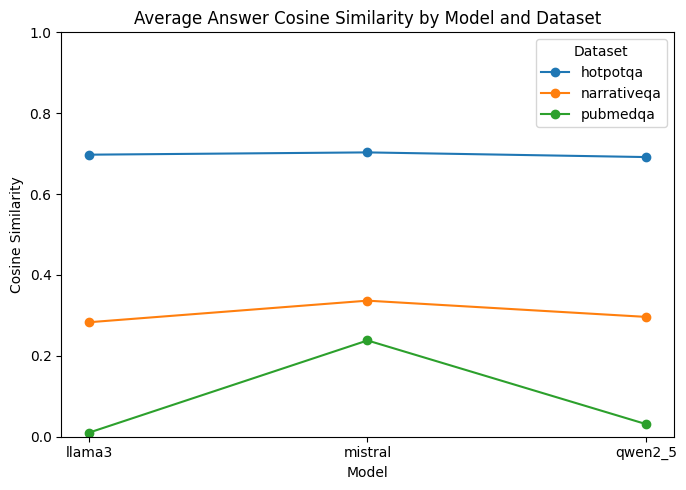

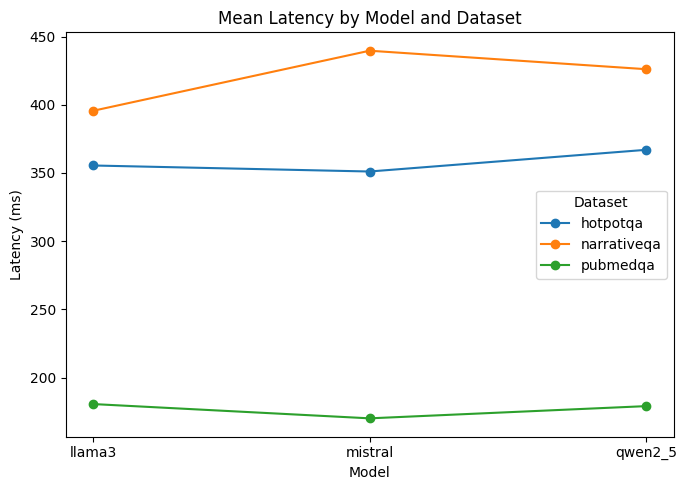

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
hotpot = pd.read_csv("./hotpot.csv")
narrative = pd.read_csv("./narrative.csv")
pubmed = pd.read_csv("./pubmed.csv")

df = pd.concat([hotpot, narrative, pubmed], ignore_index=True)

# Aggregate metrics
agg = (
    df.groupby(["dataset", "model"])
      .agg(
          mean_cosine=("answer_cosine_sim", "mean"),
          mean_latency=("client_elapsed_ms", "mean"),
      )
      .reset_index()
)

# Ensure consistent model order
model_order = ["llama3", "mistral", "qwen2_5"]

# ---------- Combined cosine similarity line chart ----------
plt.figure(figsize=(7, 5))
for dataset in agg["dataset"].unique():
    subset = agg[agg["dataset"] == dataset].set_index("model").loc[model_order].reset_index()
    plt.plot(subset["model"], subset["mean_cosine"], marker="o", label=dataset)

plt.title("Average Answer Cosine Similarity by Model and Dataset")
plt.xlabel("Model")
plt.ylabel("Cosine Similarity")
plt.ylim(0, 1)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

# ---------- Combined latency line chart ----------
plt.figure(figsize=(7, 5))
for dataset in agg["dataset"].unique():
    subset = agg[agg["dataset"] == dataset].set_index("model").loc[model_order].reset_index()
    plt.plot(subset["model"], subset["mean_latency"], marker="o", label=dataset)

plt.title("Mean Latency by Model and Dataset")
plt.xlabel("Model")
plt.ylabel("Latency (ms)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


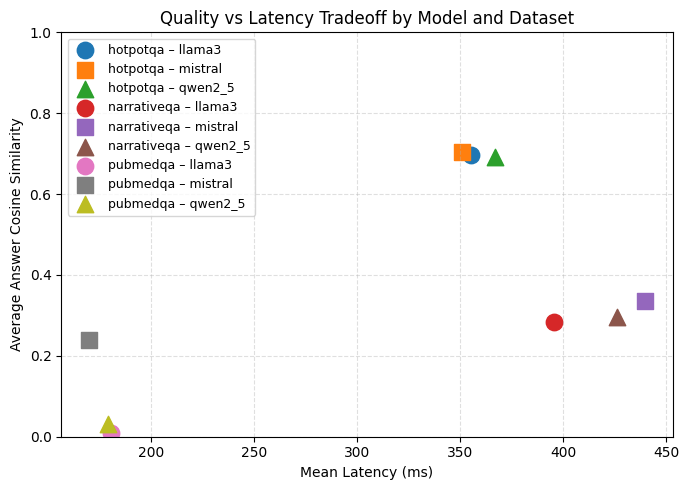

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
hotpot = pd.read_csv("./hotpot.csv")
narrative = pd.read_csv("./narrative.csv")
pubmed = pd.read_csv("./pubmed.csv")

df = pd.concat([hotpot, narrative, pubmed], ignore_index=True)

# Aggregate metrics
agg = (
    df.groupby(["dataset", "model"])
      .agg(
          mean_cosine=("answer_cosine_sim", "mean"),
          mean_latency=("client_elapsed_ms", "mean"),
      )
      .reset_index()
)

# Marker per model
model_markers = {
    "llama3": "o",
    "mistral": "s",
    "qwen2_5": "^",
}

plt.figure(figsize=(7, 5))

for dataset in agg["dataset"].unique():
    for model, marker in model_markers.items():
        subset = agg[(agg["dataset"] == dataset) & (agg["model"] == model)]
        if not subset.empty:
            plt.scatter(
                subset["mean_latency"],
                subset["mean_cosine"],
                marker=marker,
                s=140,
                label=f"{dataset} – {model}"
            )

plt.title("Quality vs Latency Tradeoff by Model and Dataset")
plt.xlabel("Mean Latency (ms)")
plt.ylabel("Average Answer Cosine Similarity")
plt.ylim(0, 1)

# Deduplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=9)

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


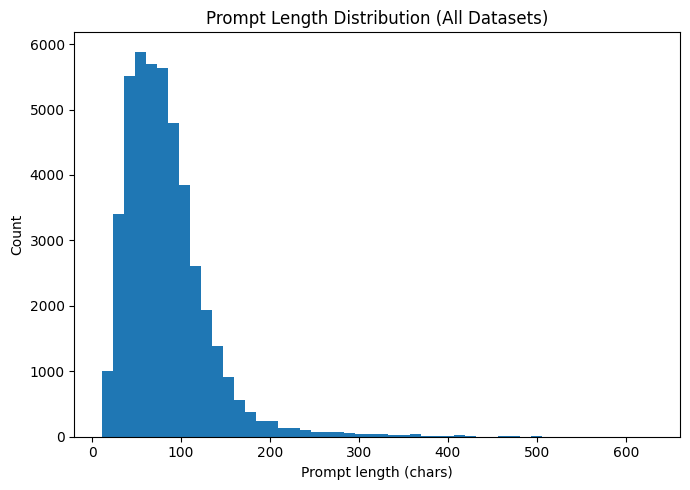

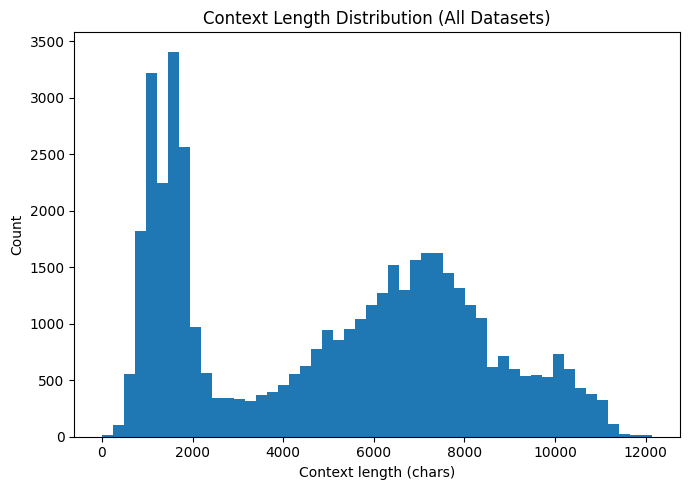

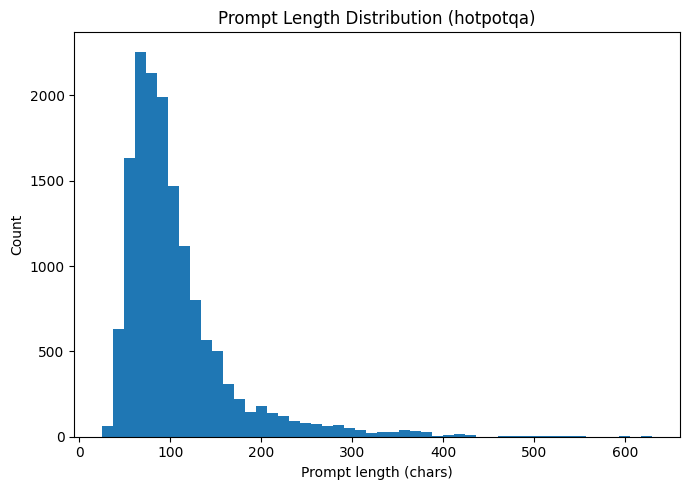

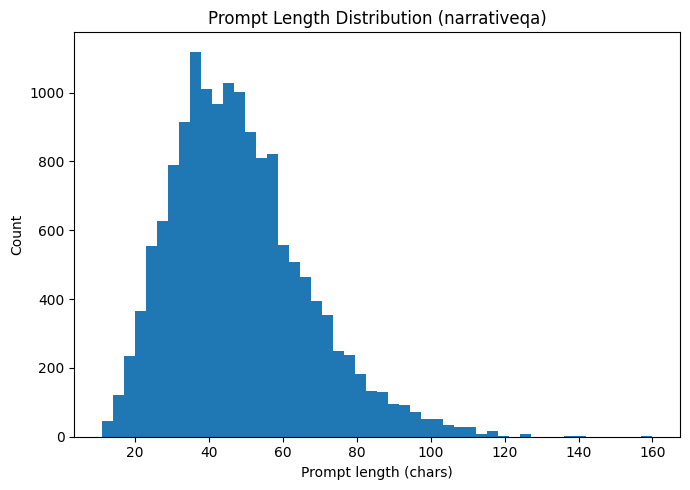

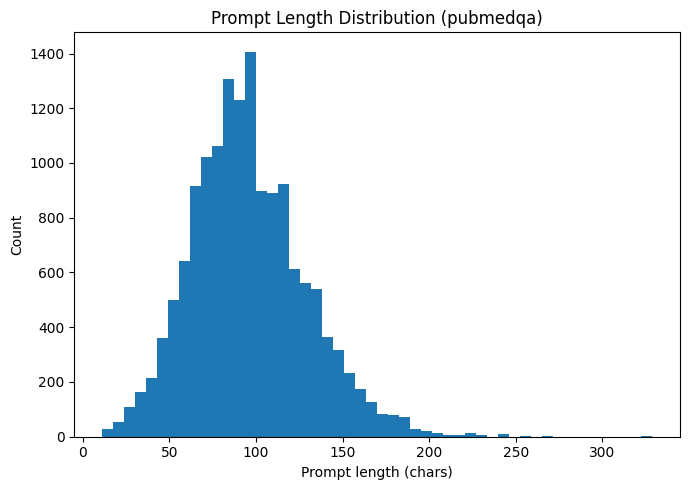

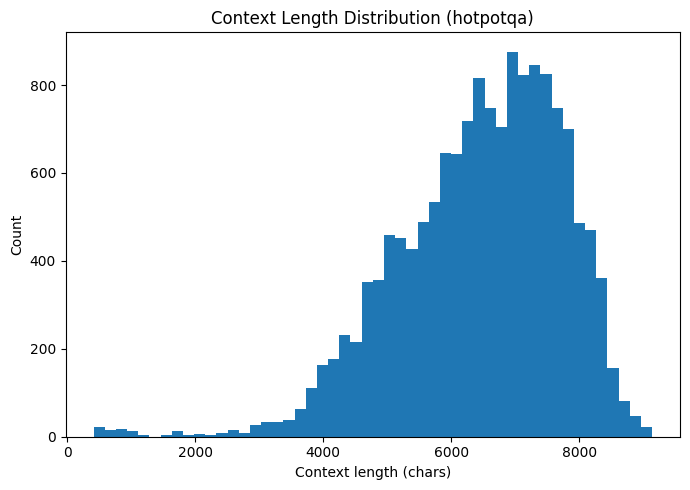

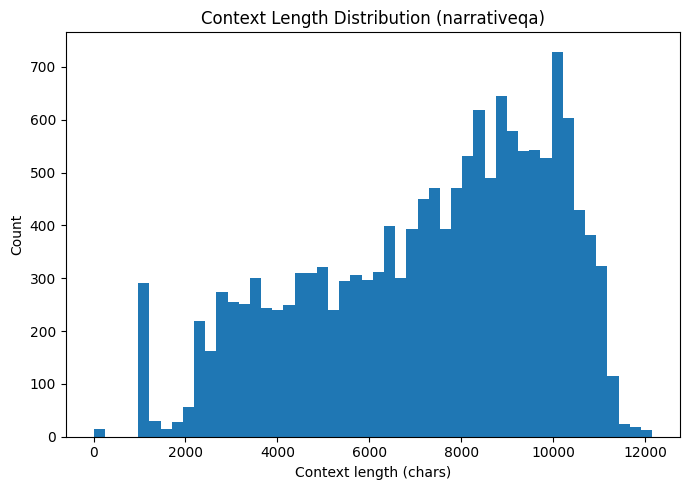

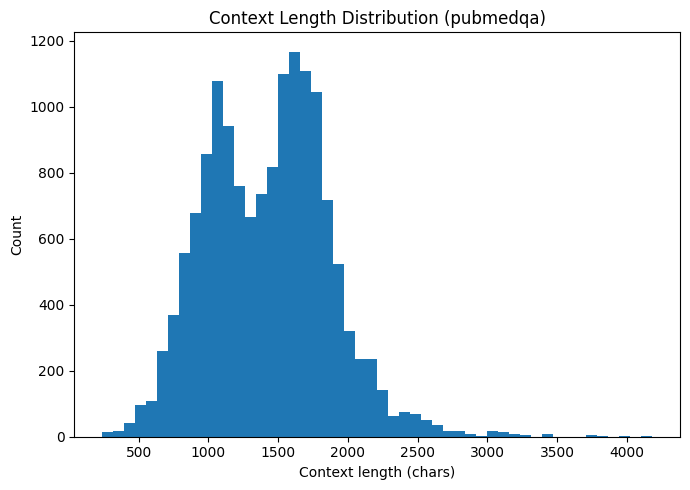

prompt_chars                         context_chars           \
                   count    mean median min  max         count     mean   
dataset                                                                   
hotpotqa           15000  106.53   90.0  25  630         15000  6452.43   
narrativeqa        15000   48.08   46.0  11  160         15000  7287.43   
pubmedqa           15000   95.86   93.0  11  329         15000  1430.43   

                                 
             median  min    max  
dataset                          
hotpotqa     6604.5  413   9134  
narrativeqa  7821.0    0  12153  
pubmedqa     1451.5  236   4185

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data (uploaded earlier in this session)
hotpot = pd.read_csv("./hotpot.csv")
narrative = pd.read_csv("./narrative.csv")
pubmed = pd.read_csv("./pubmed.csv")

df = pd.concat([hotpot, narrative, pubmed], ignore_index=True)

# Keep only columns we need and ensure numeric
for col in ["prompt_chars", "context_chars"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

datasets = sorted(df["dataset"].dropna().unique())

# 1) Prompt length distribution (all datasets)
plt.figure(figsize=(7, 5))
plt.hist(df["prompt_chars"], bins=50)
plt.title("Prompt Length Distribution (All Datasets)")
plt.xlabel("Prompt length (chars)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Context length distribution (all datasets)
plt.figure(figsize=(7, 5))
plt.hist(df["context_chars"], bins=50)
plt.title("Context Length Distribution (All Datasets)")
plt.xlabel("Context length (chars)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3) Prompt length distribution per dataset (separate charts)
for ds in datasets:
    sub = df[df["dataset"] == ds]
    plt.figure(figsize=(7, 5))
    plt.hist(sub["prompt_chars"], bins=50)
    plt.title(f"Prompt Length Distribution ({ds})")
    plt.xlabel("Prompt length (chars)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 4) Context length distribution per dataset (separate charts)
for ds in datasets:
    sub = df[df["dataset"] == ds]
    plt.figure(figsize=(7, 5))
    plt.hist(sub["context_chars"], bins=50)
    plt.title(f"Context Length Distribution ({ds})")
    plt.xlabel("Context length (chars)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 5) Summary stats table for slides
summary = (
    df.groupby("dataset")[["prompt_chars", "context_chars"]]
      .agg(["count", "mean", "median", "min", "max"])
      .round(2)
)
summary


/tmp/ipykernel_2151320/175138955.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["dataset", "context_bin"])


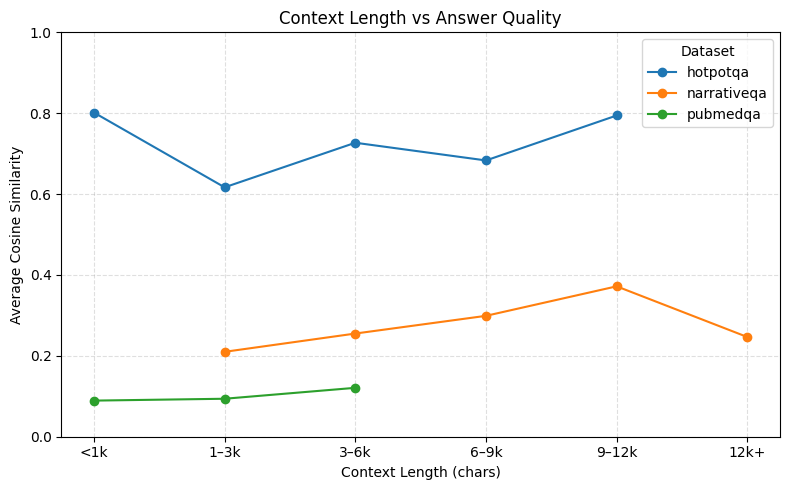

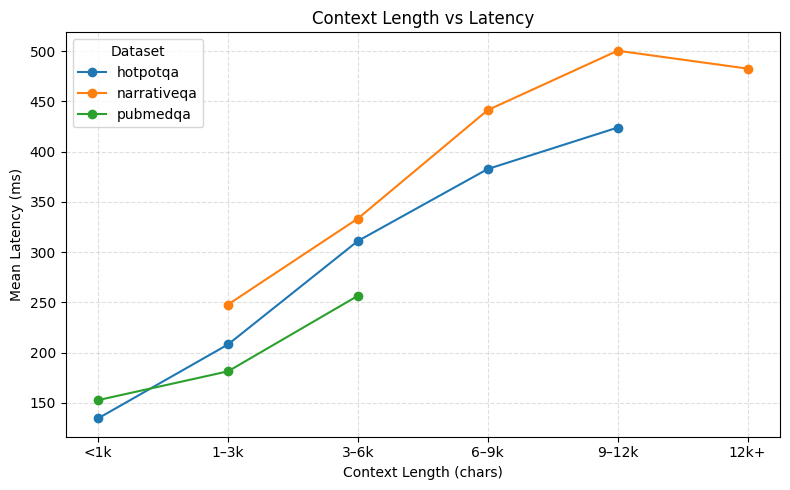

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
hotpot = pd.read_csv("./hotpot.csv")
narrative = pd.read_csv("./narrative.csv")
pubmed = pd.read_csv("./pubmed.csv")

df = pd.concat([hotpot, narrative, pubmed], ignore_index=True)

# Bin context length
df["context_bin"] = pd.cut(
    df["context_chars"],
    bins=[0, 1000, 3000, 6000, 9000, 12000, 20000],
    labels=["<1k", "1–3k", "3–6k", "6–9k", "9–12k", "12k+"],
)

# Aggregate accuracy & latency per bin and dataset
agg = (
    df.groupby(["dataset", "context_bin"])
      .agg(
          mean_cosine=("answer_cosine_sim", "mean"),
          mean_latency=("client_elapsed_ms", "mean"),
          count=("question_id", "nunique"),
      )
      .reset_index()
)

# ---------- Context length vs cosine similarity ----------
plt.figure(figsize=(8, 5))

for dataset in agg["dataset"].unique():
    subset = agg[agg["dataset"] == dataset]
    plt.plot(
        subset["context_bin"].astype(str),
        subset["mean_cosine"],
        marker="o",
        label=dataset
    )

plt.title("Context Length vs Answer Quality")
plt.xlabel("Context Length (chars)")
plt.ylabel("Average Cosine Similarity")
plt.ylim(0, 1)
plt.legend(title="Dataset")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# ---------- Context length vs latency ----------
plt.figure(figsize=(8, 5))

for dataset in agg["dataset"].unique():
    subset = agg[agg["dataset"] == dataset]
    plt.plot(
        subset["context_bin"].astype(str),
        subset["mean_latency"],
        marker="o",
        label=dataset
    )

plt.title("Context Length vs Latency")
plt.xlabel("Context Length (chars)")
plt.ylabel("Mean Latency (ms)")
plt.legend(title="Dataset")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


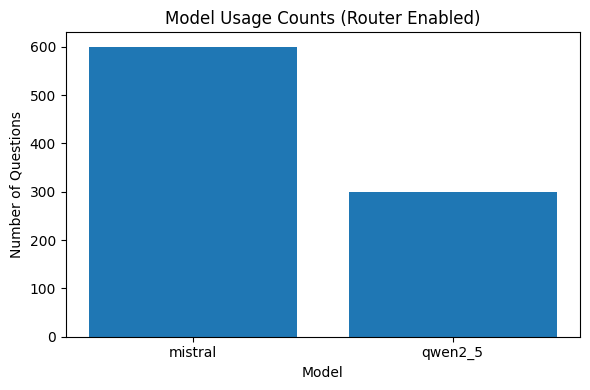

,model,count
0,mistral,600
1,qwen2_5,300


In [128]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./evaluation_results_inference_dataset.csv")

# --------------------
# Model usage counts
# --------------------
model_counts = df["routed_variant"].value_counts().reset_index()
model_counts.columns = ["model", "count"]

plt.figure(figsize=(6, 4))
plt.bar(model_counts["model"], model_counts["count"])
plt.title("Model Usage Counts (Router Enabled)")
plt.xlabel("Model")
plt.ylabel("Number of Questions")
plt.tight_layout()
plt.show()

model_counts


In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Load router-enabled dataset-policy inference results
df = pd.read_csv("./evaluation_results_inference_dataset.csv")
df.columns
# Ensure numeric
df["answer_cosine_sim"] = pd.to_numeric(df["answer_cosine_sim"], errors="coerce")

# --------------------
# Cosine similarity per dataset and routed model
# --------------------
cosine_by_ds_model = (
    df.groupby(["dataset", "routed_variant"])
      .agg(
          mean_cosine=("answer_cosine_sim", "mean"),
           mean_latency=("end_to_end_ms", "mean"),
          count=("question_id", "nunique"),
      )
      .reset_index()
)

cosine_by_ds_model


,dataset,routed_variant,mean_cosine,mean_latency,count
0,hotpotqa,qwen2_5,0.655734,324.396267,300
1,narrativeqa,mistral,0.353230,365.782356,300
2,pubmedqa,mistral,0.236548,148.214912,300


In [133]:
df.columns


Index(['ts_ms', 'collection', 'dataset', 'story_id', 'question_id',
       'question_hash', 'question', 'true_answer', 'predicted_answer',
       'requested_variant', 'routed_variant', 'routed_by', 'retrieval_k',
       'local_retrieval_ms', 'grpc_elapsed_ms', 'router_retrieval_ms',
       'inference_ms', 'end_to_end_ms', 'prompt_chars', 'context_chars',
       'answer_chars', 'exact_match', 'answer_cosine_sim', 'type', 'level'],
      dtype='object')

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ML-based router inference results
df = pd.read_csv("./evaluation_results_inference_ml.csv")

# Ensure numeric
df["answer_cosine_sim"] = pd.to_numeric(df["answer_cosine_sim"], errors="coerce")
df["end_to_end_ms"] = pd.to_numeric(df["end_to_end_ms"], errors="coerce")
df["exact_match"] = pd.to_numeric(df["exact_match"], errors="coerce")

# --------------------
# 1) Cosine similarity per dataset and routed model (ML router)
# --------------------
cosine_by_ds_model = (
    df.groupby(["dataset", "routed_variant"])
      .agg(
          mean_cosine=("answer_cosine_sim", "mean"),
          em_rate=("exact_match", "mean"),
          mean_latency=("end_to_end_ms", "mean"),
          count=("question_id", "nunique"),
      )
      .reset_index()
)

cosine_by_ds_model


,dataset,routed_variant,mean_cosine,em_rate,mean_latency,count
0,hotpotqa,llama3,0.751629,0.571429,293.721953,77
1,hotpotqa,mistral,0.870826,0.678571,209.791521,28
2,hotpotqa,qwen2_5,0.597160,0.338462,346.132284,195
3,narrativeqa,llama3,0.305930,0.000000,371.175908,300
4,pubmedqa,mistral,0.240653,0.000000,152.463974,288
5,pubmedqa,qwen2_5,-0.008202,0.000000,170.616461,12


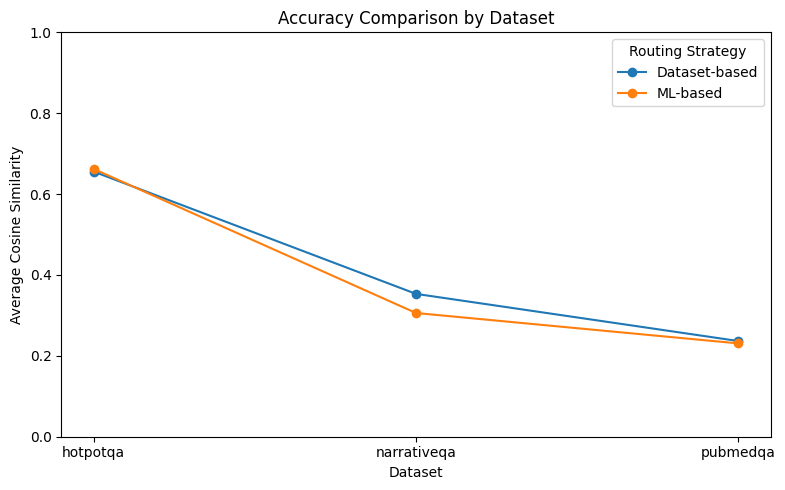

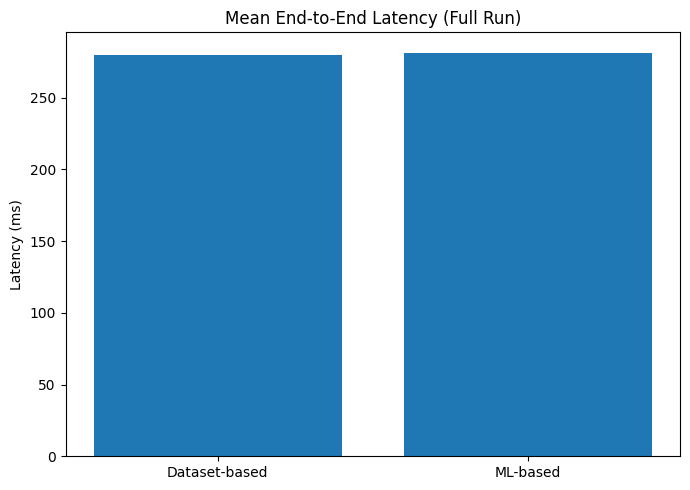

,routing,mean_latency,p90_latency
0,Dataset-based,279.464512,432.973406
1,ML-based,281.440381,383.087515


In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both inference result files
df_dataset = pd.read_csv("./evaluation_results_inference_dataset.csv")
df_ml = pd.read_csv("./evaluation_results_inference_ml.csv")

# Ensure numeric columns
for df in [df_dataset, df_ml]:
    df["answer_cosine_sim"] = pd.to_numeric(df["answer_cosine_sim"], errors="coerce")
    df["end_to_end_ms"] = pd.to_numeric(df["end_to_end_ms"], errors="coerce")

# --------------------
# 1) Accuracy comparison by dataset
# --------------------
acc_dataset = (
    df_dataset.groupby("dataset")
    .agg(mean_cosine=("answer_cosine_sim", "mean"))
    .reset_index()
)
acc_dataset["routing"] = "Dataset-based"

acc_ml = (
    df_ml.groupby("dataset")
    .agg(mean_cosine=("answer_cosine_sim", "mean"))
    .reset_index()
)
acc_ml["routing"] = "ML-based"

acc_compare = pd.concat([acc_dataset, acc_ml], ignore_index=True)

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
for routing in acc_compare["routing"].unique():
    sub = acc_compare[acc_compare["routing"] == routing]
    plt.plot(sub["dataset"], sub["mean_cosine"], marker="o", label=routing)

plt.title("Accuracy Comparison by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Average Cosine Similarity")
plt.ylim(0, 1)
plt.legend(title="Routing Strategy")
plt.tight_layout()
plt.show()

# --------------------
# 2) Latency comparison (full run)
# --------------------
latency_compare = pd.DataFrame({
    "routing": ["Dataset-based", "ML-based"],
    "mean_latency": [
        df_dataset["end_to_end_ms"].mean(),
        df_ml["end_to_end_ms"].mean(),
    ],
    "p90_latency": [
        df_dataset["end_to_end_ms"].quantile(0.9),
        df_ml["end_to_end_ms"].quantile(0.9),
    ],
})

# Plot latency comparison
plt.figure(figsize=(7, 5))
plt.bar(latency_compare["routing"], latency_compare["mean_latency"])
plt.title("Mean End-to-End Latency (Full Run)")
plt.ylabel("Latency (ms)")
plt.tight_layout()
plt.show()

latency_compare


In [ ]:
#!/usr/bin/env python3
import os
import glob
import joblib
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)


def pick_best_model(group: pd.DataFrame) -> str:
    em_w = float(os.getenv("ROUTER_EM_WEIGHT", "0.25"))
    lat_w = float(os.getenv("ROUTER_LAT_WEIGHT", "0.0002"))

    inf_ms = group.get("inference_ms", pd.Series([0.0] * len(group))).fillna(
        group.get("client_elapsed_ms", pd.Series([0.0] * len(group))).fillna(0.0)
    )

    utility = (
        group.get("answer_cosine_sim", 0.0).fillna(0.0)
        + em_w * group.get("exact_match", 0.0).fillna(0.0)
        - lat_w * inf_ms
    )
    best_idx = utility.idxmax()
    return str(group.loc[best_idx, "model"])


def print_header(title: str) -> None:
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)


def main() -> None:
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    out_path = os.getenv("ROUTER_MODEL_PATH", "/data/router.joblib")
    test_size = float(os.getenv("ROUTER_TEST_SIZE", "0.2"))
    seed = int(os.getenv("ROUTER_SEED", "42"))

    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    # Normalize dataset / collection
    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("").astype(str).str.strip().str.lower()
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    # Ensure feature cols exist
    for c in ["prompt_chars", "context_chars"]:
        if c not in df.columns:
            df[c] = 0

    required = ["question_id", "model", "answer_cosine_sim", "exact_match"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise SystemExit(f"Missing required columns in eval CSV(s): {missing}")

    key = "question_id"

    # ---- Raw data summary ----
    print_header("Raw data summary (before building labels)")
    print(f"CSV files: {len(csvs)}")
    print(f"Rows (model-runs): {len(df):,}")
    print(f"Unique questions: {df[key].nunique():,}")
    print(f"Unique models: {df['model'].nunique():,}")

    print("\nTop datasets (by runs):")
    print(df["dataset"].value_counts().head(20).to_string())

    print("\nFeature stats (runs):")
    print(df[["prompt_chars", "context_chars"]].describe().to_string())

    print("\nLatency columns present:",
          {"inference_ms" in df.columns, "client_elapsed_ms" in df.columns})

    # ---- Build target y ----
    try:
        y = df.groupby(key, include_groups=False).apply(pick_best_model)
    except TypeError:
        y = df.groupby(key).apply(pick_best_model)

    first = df.groupby(key).first().copy()
    X = first[["dataset", "prompt_chars", "context_chars"]].copy()
    X = X.loc[y.index]

    print_header("Target label summary (best model per question)")
    print(y.value_counts().to_string())

    # ---- Train/test split ----
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed
        )

    # ---- Train pipeline ----
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), ["dataset"]),
            ("num", "passthrough", ["prompt_chars", "context_chars"]),
        ]
    )

    clf = LogisticRegression(max_iter=10000, class_weight="balanced")
    pipe = Pipeline(steps=[("pre", pre), ("clf", clf)])
    pipe.fit(X_train, y_train)

    # ---- Test evaluation ----
    y_pred = pipe.predict(X_test)

    print_header("Test results")
    print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    labels = sorted(pd.unique(pd.concat([y_test, pd.Series(y_pred)])))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_df = pd.DataFrame(
        cm,
        index=[f"true:{l}" for l in labels],
        columns=[f"pred:{l}" for l in labels],
    )
    print("\nConfusion matrix:")
    print(cm_df.to_string())

    # ---- Save artifact ----
    obj = {
        "router_type": "ml",
        "ml_model": pipe,
        "meta": {
            "em_weight": float(os.getenv("ROUTER_EM_WEIGHT", "0.25")),
            "lat_weight": float(os.getenv("ROUTER_LAT_WEIGHT", "0.0002")),
            "test_size": test_size,
            "seed": seed,
        },
    }

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    joblib.dump(obj, out_path)

    print_header("Saved")
    print(f"Saved ML router artifact: {out_path}")


if __name__ == "__main__":
    main()



Raw data summary (before building labels)
CSV files: 3
Rows (model-runs): 45,000
Unique questions: 15,000
Unique models: 3

Top datasets (by runs):
dataset
hotpotqa       15000
narrativeqa    15000
pubmedqa       15000

Feature stats (runs):
       prompt_chars  context_chars
count  45000.000000   45000.000000
mean      83.491600    5056.765933
std       48.900883    3101.038751
min       11.000000       0.000000
25%       51.000000    1693.000000
50%       75.000000    5525.000000
75%      103.250000    7525.250000
max      630.000000   12153.000000

Latency columns present: {True}


/tmp/ipykernel_2151320/3270481504.py:198: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y = df.groupby(key).apply(pick_best_model)



Target label summary (best model per question)
mistral    10094
llama3      3254
qwen2_5     1652

Test results
Accuracy:          0.4673
Balanced accuracy: 0.4631

Classification report:
              precision    recall  f1-score   support

      llama3       0.34      0.63      0.44       651
     mistral       0.84      0.44      0.58      2019
     qwen2_5       0.15      0.32      0.20       330

    accuracy                           0.47      3000
   macro avg       0.44      0.46      0.41      3000
weighted avg       0.65      0.47      0.51      3000


Confusion matrix:
              pred:llama3  pred:mistral  pred:qwen2_5
true:llama3           407            55           189
true:mistral          699           888           432
true:qwen2_5          108           115           107

Model input variables
Raw input columns used by the model: ['dataset', 'prompt_chars', 'context_chars']

Expanded feature names after preprocessing (one-hot + numeric):
['dataset_hotpotqa', 'dat

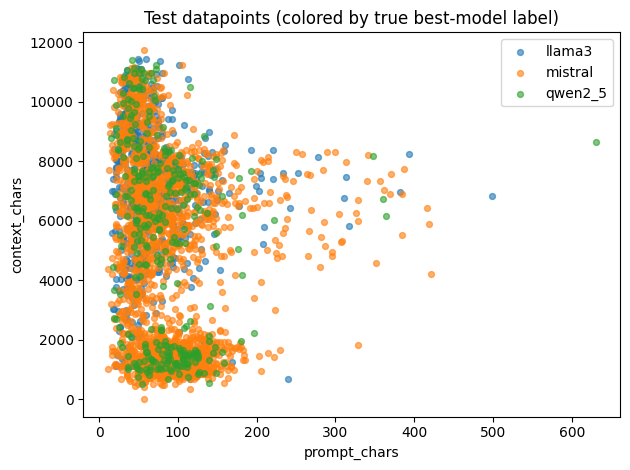

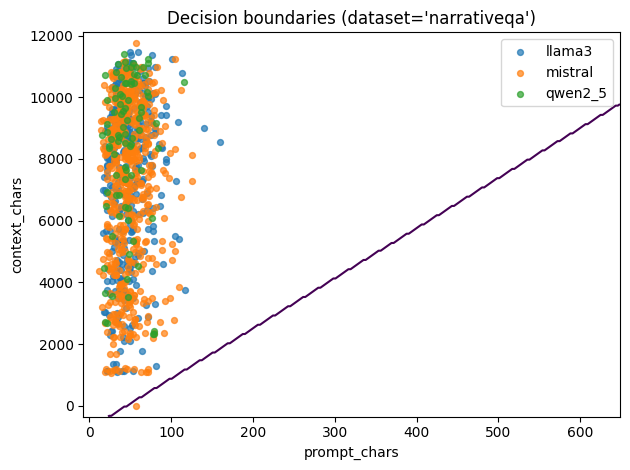

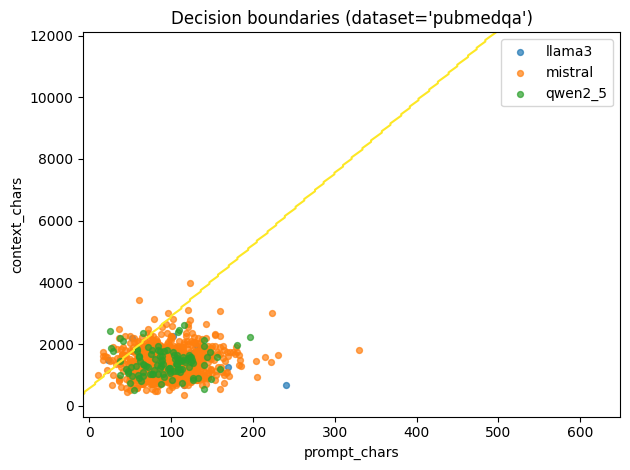

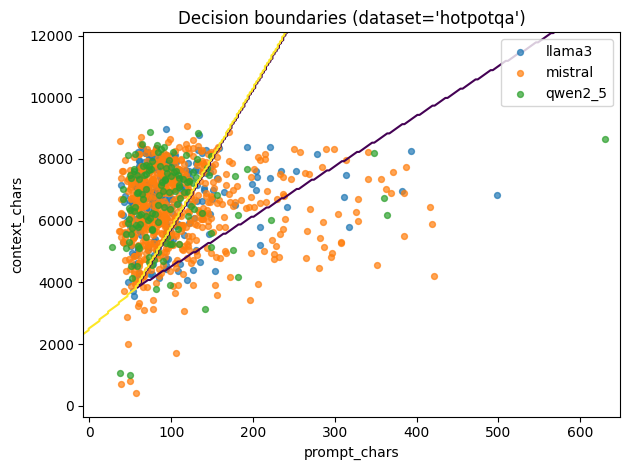

In [138]:
#!/usr/bin/env python3
import os
import glob
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)


def pick_best_model(group: pd.DataFrame) -> str:
    em_w = float(os.getenv("ROUTER_EM_WEIGHT", "0.25"))
    lat_w = float(os.getenv("ROUTER_LAT_WEIGHT", "0.0002"))

    inf_ms = group.get("inference_ms", pd.Series([0.0] * len(group))).fillna(
        group.get("client_elapsed_ms", pd.Series([0.0] * len(group))).fillna(0.0)
    )

    utility = (
        group.get("answer_cosine_sim", 0.0).fillna(0.0)
        + em_w * group.get("exact_match", 0.0).fillna(0.0)
        - lat_w * inf_ms
    )
    best_idx = utility.idxmax()
    return str(group.loc[best_idx, "model"])


def print_header(title: str) -> None:
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)


def plot_points_and_boundaries(
    pipe: Pipeline,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    top_k_datasets: int = 3,
    grid_size: int = 250,
) -> None:
    """
    1) Scatter plot of datapoints in (prompt_chars, context_chars), colored by y_test.
    2) Decision boundaries ("regression lines") for a few dataset slices, since dataset is categorical.
    """

    # ---- Plot 1: all test points ----
    plt.figure()
    labels = sorted(pd.unique(y_test))
    for lab in labels:
        m = (y_test == lab).to_numpy()
        plt.scatter(
            X_test.loc[m, "prompt_chars"],
            X_test.loc[m, "context_chars"],
            label=str(lab),
            alpha=0.6,
            s=18,
        )

    plt.xlabel("prompt_chars")
    plt.ylabel("context_chars")
    plt.title("Test datapoints (colored by true best-model label)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # ---- Plot 2+: dataset-specific boundaries ----
    top_datasets = X_test["dataset"].value_counts().head(top_k_datasets).index.tolist()
    if not top_datasets:
        print("No datasets found in X_test; skipping boundary plots.")
        return

    x_min, x_max = float(X_test["prompt_chars"].min()), float(X_test["prompt_chars"].max())
    y_min, y_max = float(X_test["context_chars"].min()), float(X_test["context_chars"].max())

    # Add a tiny padding so points aren't on the border
    pad_x = (x_max - x_min) * 0.03 if x_max > x_min else 1.0
    pad_y = (y_max - y_min) * 0.03 if y_max > y_min else 1.0
    x_min, x_max = x_min - pad_x, x_max + pad_x
    y_min, y_max = y_min - pad_y, y_max + pad_y

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
    )

    # Map class labels -> integer codes for contouring
    class_list = list(pipe.named_steps["clf"].classes_)
    class_to_code = {c: i for i, c in enumerate(class_list)}

    for ds in top_datasets:
        grid = pd.DataFrame(
            {
                "dataset": ds,
                "prompt_chars": xx.ravel(),
                "context_chars": yy.ravel(),
            }
        )

        # Predict class for each grid point
        Z_pred = pipe.predict(grid)
        Z = np.vectorize(class_to_code.get)(Z_pred).reshape(xx.shape)

        plt.figure()

        # Scatter points belonging to this dataset slice
        mds = (X_test["dataset"] == ds).to_numpy()
        for lab in labels:
            m = mds & (y_test == lab).to_numpy()
            if m.any():
                plt.scatter(
                    X_test.loc[m, "prompt_chars"],
                    X_test.loc[m, "context_chars"],
                    label=str(lab),
                    alpha=0.7,
                    s=18,
                )

        # Decision boundaries between predicted classes
        # Contour at half-integers to draw boundaries between integer regions.
        levels = [i + 0.5 for i in range(len(class_list) - 1)]
        plt.contour(xx, yy, Z, levels=levels)

        plt.xlabel("prompt_chars")
        plt.ylabel("context_chars")
        plt.title(f"Decision boundaries (dataset='{ds}')")
        plt.legend(loc="best")
        plt.tight_layout()
        plt.show()


def main() -> None:
    results_glob = os.getenv("ROUTER_TRAIN_GLOB", "/data/results/**/evaluation_results.csv")
    out_path = os.getenv("ROUTER_MODEL_PATH", "/data/router.joblib")
    test_size = float(os.getenv("ROUTER_TEST_SIZE", "0.2"))
    seed = int(os.getenv("ROUTER_SEED", "42"))

    csvs = sorted(glob.glob(results_glob, recursive=True))
    if not csvs:
        raise SystemExit(f"No CSVs found for ROUTER_TRAIN_GLOB={results_glob}")

    df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)

    # Normalize dataset / collection
    if "dataset" not in df.columns:
        df["dataset"] = ""
    if "collection" not in df.columns:
        df["collection"] = "unknown"

    df["dataset"] = df["dataset"].fillna("").astype(str).str.strip().str.lower()
    df["collection"] = df["collection"].fillna("").astype(str).str.strip().str.lower()
    df.loc[df["dataset"] == "", "dataset"] = df.loc[df["dataset"] == "", "collection"]
    df.loc[df["dataset"] == "", "dataset"] = "unknown"

    # Ensure feature cols exist
    for c in ["prompt_chars", "context_chars"]:
        if c not in df.columns:
            df[c] = 0

    required = ["question_id", "model", "answer_cosine_sim", "exact_match"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise SystemExit(f"Missing required columns in eval CSV(s): {missing}")

    key = "question_id"

    # ---- Raw data summary ----
    print_header("Raw data summary (before building labels)")
    print(f"CSV files: {len(csvs)}")
    print(f"Rows (model-runs): {len(df):,}")
    print(f"Unique questions: {df[key].nunique():,}")
    print(f"Unique models: {df['model'].nunique():,}")

    print("\nTop datasets (by runs):")
    print(df["dataset"].value_counts().head(20).to_string())

    print("\nFeature stats (runs):")
    print(df[["prompt_chars", "context_chars"]].describe().to_string())

    print("\nLatency columns present:",
          {"inference_ms" in df.columns, "client_elapsed_ms" in df.columns})

    # ---- Build target y ----
    try:
        y = df.groupby(key, include_groups=False).apply(pick_best_model)
    except TypeError:
        y = df.groupby(key).apply(pick_best_model)

    first = df.groupby(key).first().copy()
    X = first[["dataset", "prompt_chars", "context_chars"]].copy()
    X = X.loc[y.index]

    print_header("Target label summary (best model per question)")
    print(y.value_counts().to_string())

    # ---- Train/test split ----
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed, stratify=y
        )
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=seed
        )

    # ---- Train pipeline ----
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), ["dataset"]),
            ("num", "passthrough", ["prompt_chars", "context_chars"]),
        ]
    )

    clf = LogisticRegression(max_iter=10000, class_weight="balanced")
    pipe = Pipeline(steps=[("pre", pre), ("clf", clf)])
    pipe.fit(X_train, y_train)

    # ---- Test evaluation ----
    y_pred = pipe.predict(X_test)

    print_header("Test results")
    print(f"Accuracy:          {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    labels = sorted(pd.unique(pd.concat([y_test, pd.Series(y_pred)])))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_df = pd.DataFrame(
        cm,
        index=[f"true:{l}" for l in labels],
        columns=[f"pred:{l}" for l in labels],
    )
    print("\nConfusion matrix:")
    print(cm_df.to_string())

    # ---- Print input variables / feature names ----
    print_header("Model input variables")
    print("Raw input columns used by the model: ['dataset', 'prompt_chars', 'context_chars']")

    ohe = pipe.named_steps["pre"].named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(["dataset"])
    feature_names = list(cat_names) + ["prompt_chars", "context_chars"]

    print("\nExpanded feature names after preprocessing (one-hot + numeric):")
    print(feature_names)

    # ---- Plot datapoints + decision boundaries ----
    print_header("Plots")
    plot_points_and_boundaries(pipe, X_test, y_test, top_k_datasets=3, grid_size=250)

    # ---- Save artifact ----
    obj = {
        "router_type": "ml",
        "ml_model": pipe,
        "meta": {
            "em_weight": float(os.getenv("ROUTER_EM_WEIGHT", "0.25")),
            "lat_weight": float(os.getenv("ROUTER_LAT_WEIGHT", "0.0002")),
            "test_size": test_size,
            "seed": seed,
        },
    }

    # os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # joblib.dump(obj, out_path)

    # print_header("Saved")
    # print(f"Saved ML router artifact: {out_path}")


if __name__ == "__main__":
    main()
